<a href="https://colab.research.google.com/github/chavi15/Soybean/blob/main/Leaf_diseases_classification_InceptionV3_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import kagglehub
sivm205_soybean_diseased_leaf_dataset_path = kagglehub.dataset_download('sivm205/soybean-diseased-leaf-dataset')

print('Data source import complete.')


100%|██████████| 1.93G/1.93G [00:19<00:00, 105MB/s] 

Extracting files...


Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from IPython.display import clear_output
import tensorflow_hub as hub

# Loading dataset

The data loading/processing/augmentation/displaying follows the code from this notebook:

https://www.kaggle.com/code/zadosaadipurwanto/resnet50-v2-classification

In this notebook, we will use Inception-V3 instead of ResNet50 to perform the classification. In adopting the same processing/displaying format as the above notebook, we can compare the obtained result using InceptionV3 with that of ResNet50.

In [7]:
train_data_dir = sivm205_soybean_diseased_leaf_dataset_path
BATCH_SIZE = 20
IMG_SIZE = (224, 224)
EPOCHS = 30
SHUFFLE_BUFFER = 1000
validation_split = 0.15

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=101,
    validation_split=validation_split,
    subset='training',
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=101,
    validation_split=validation_split,
    subset='validation',
)

Found 701 files belonging to 10 classes.
Using 596 files for training.
Found 701 files belonging to 10 classes.
Using 105 files for validation.


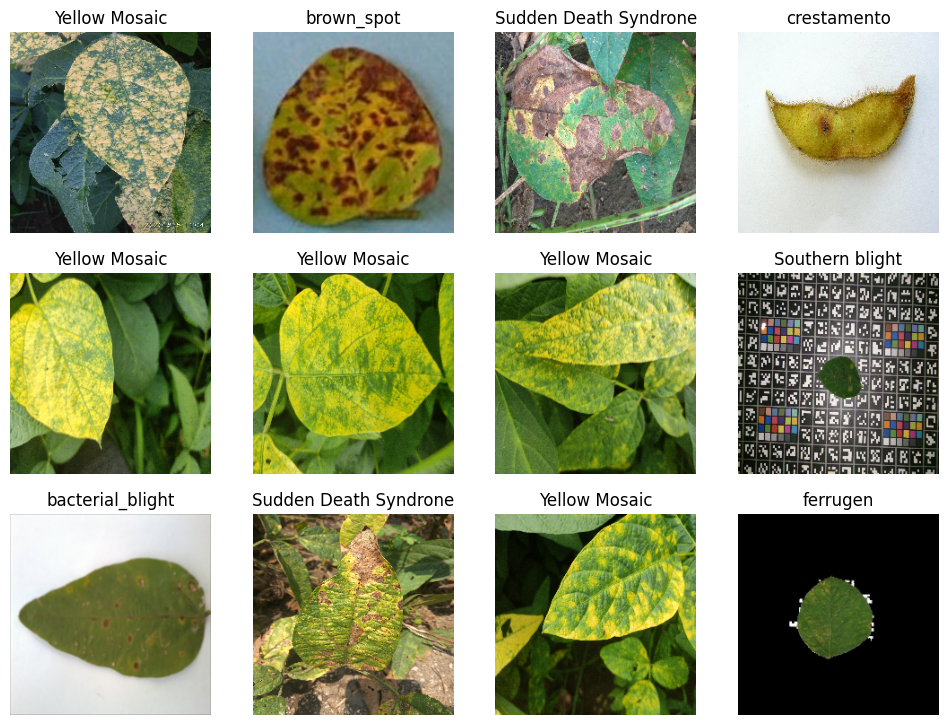

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(12):
        image = images[i].numpy()
        label = labels[i]
        class_name = class_names[tf.argmax(label)]
        plt.subplot(4, 4, i + 1)
        plt.imshow(image.astype("uint8"))
        plt.title(class_name)
        plt.axis("off")
plt.show()

## Data augmentation

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.Rescaling(1/255.)
])
normalization = layers.Rescaling(1/255.)

In [11]:
training_data = (train_dataset.map(lambda x,y: (data_augmentation(x), y))
                 .shuffle(SHUFFLE_BUFFER).prefetch(1).cache())
validation_data = (validation_dataset.map(lambda x,y: (normalization(x), y))
                   .prefetch(1).cache())

# Loading Inception-V3 model

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model

In [13]:
#use all except for the last layer (specific to the 'imagenet' competition)
pretrained_model = InceptionV3(input_shape = (224, 224,3),
                              include_top = False,
                              weights = 'imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='model.weights.h5',

    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4,
        restore_best_weights=True
    ),
]

In [21]:
#make all layer in the pretrained Inception-V3 non-trainable
for layer in pretrained_model.layers:
    layer.trainable = False

In [22]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = pretrained_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(250, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 250)            │       512,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,317,544 (85.13 MB)

 Trainable params: 514,760 (1.96 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

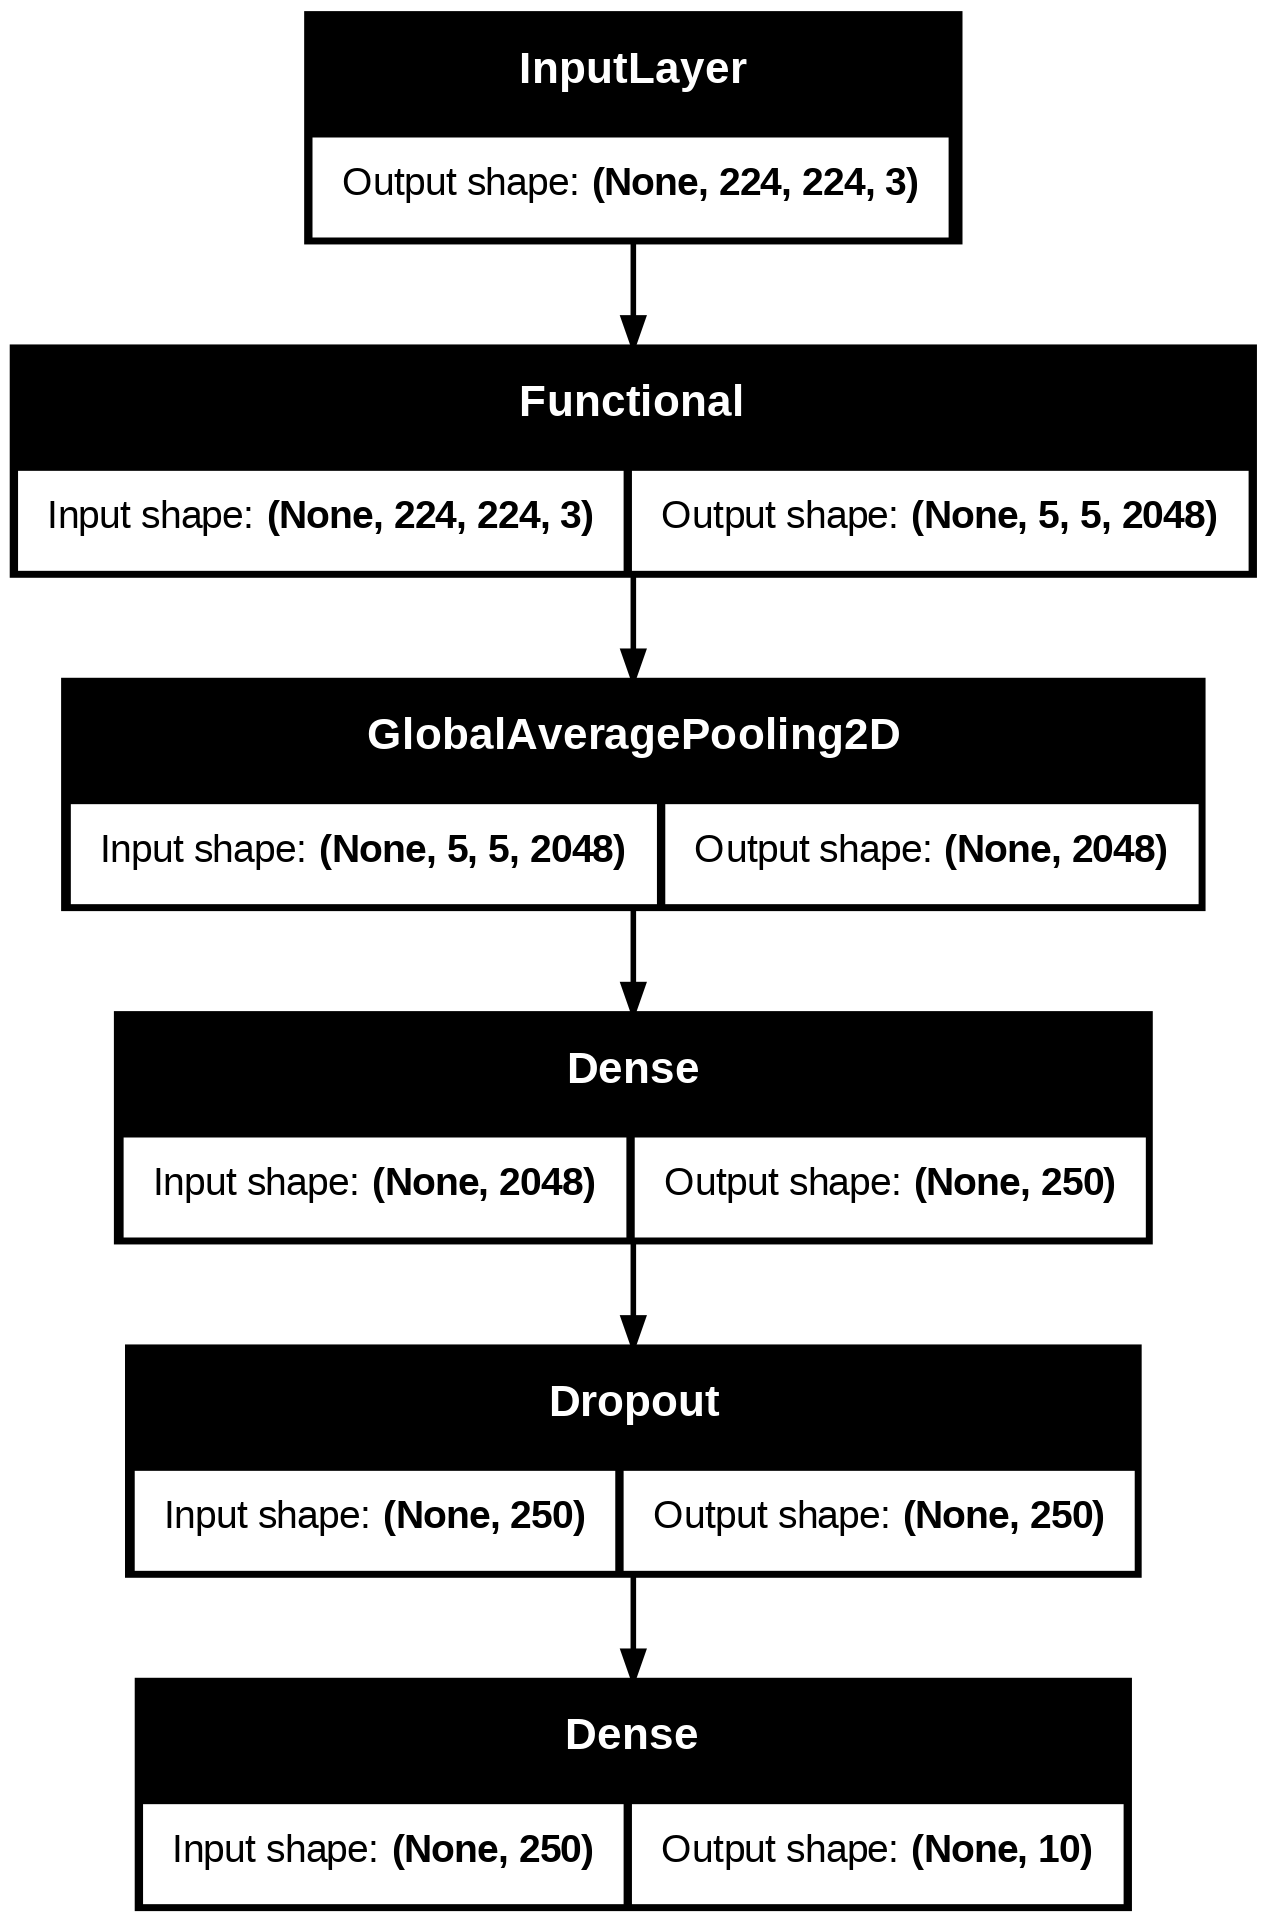

In [23]:
plot_model(model, show_shapes=True)

In [24]:
model.compile(loss='categorical_crossentropy',
             optimizer=rmsprop,
             metrics=['accuracy'])

history = model.fit(training_data,
                    epochs=EPOCHS,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.2370 - loss: 2.1947 - val_accuracy: 0.6667 - val_loss: 1.3194
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6002 - loss: 1.2675 - val_accuracy: 0.7524 - val_loss: 0.9601
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.7646 - loss: 0.8644 - val_accuracy: 0.8190 - val_loss: 0.7595
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7951 - loss: 0.6615 - val_accuracy: 0.8286 - val_loss: 0.6603
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.8454 - loss: 0.5333 - val_accuracy: 0.8286 - val_loss: 0.5735
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.8759 - loss: 0.4130 - val_accuracy: 0.8571 - val_loss: 0.5352
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8866 - loss: 0.4153 - val_accuracy: 0.8190 - val_loss: 0.4959
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.8918 - loss: 0.3863 - val_accuracy: 0.8762 - val_loss

In [25]:
results = model.evaluate(validation_data)

print("Validation Loss:", results[0])
print("Validation Accuracy:", results[1])

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9111 - loss: 0.2721
Validation Loss: 0.2524619996547699
Validation Accuracy: 0.9142857193946838


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


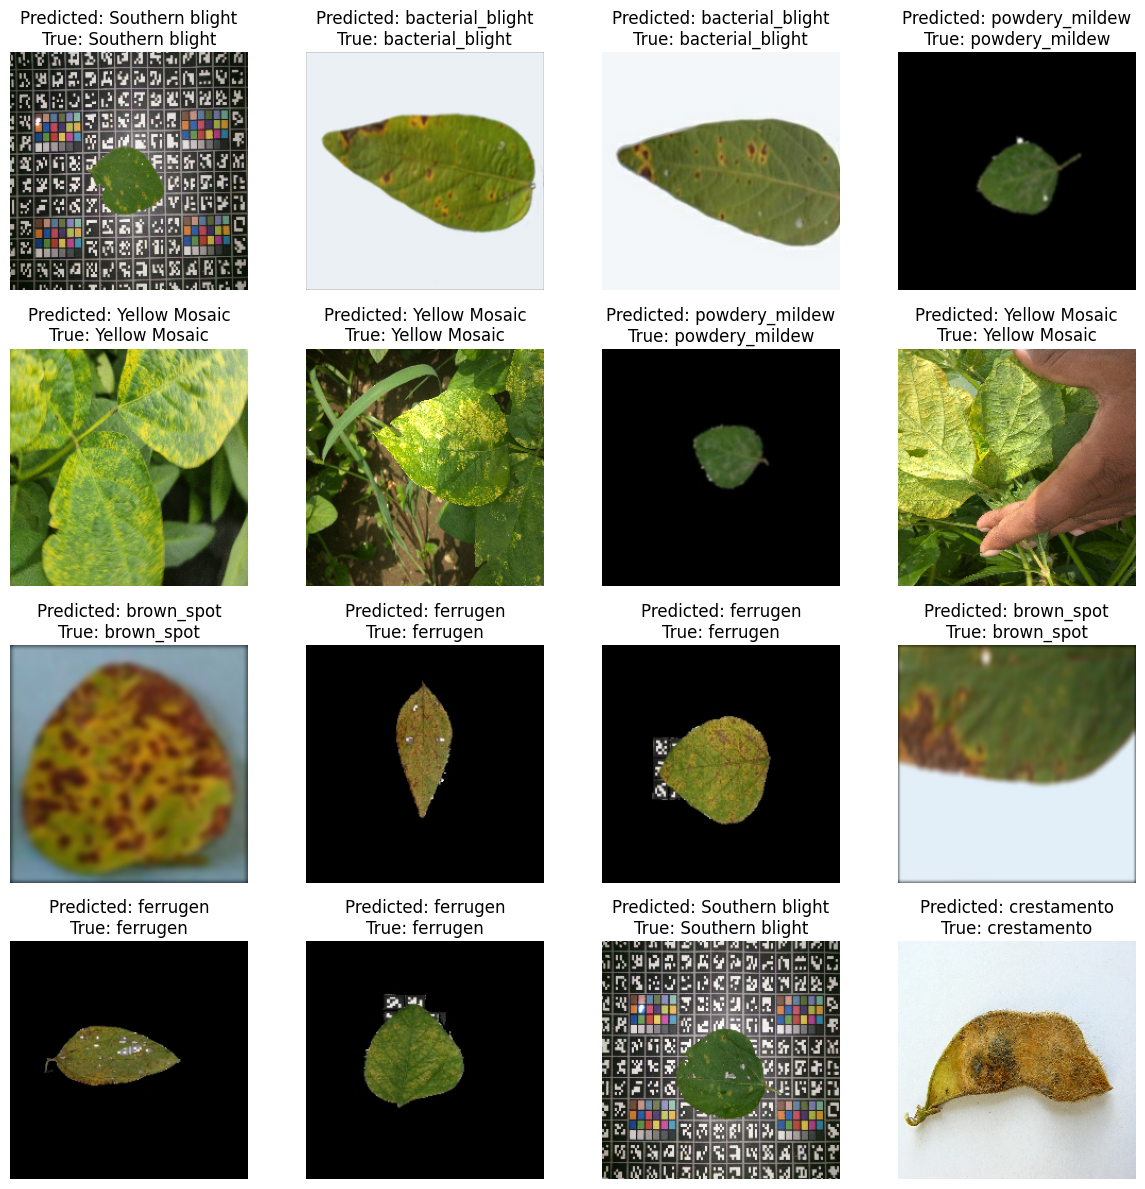

In [26]:
num_rows = 4
num_cols = 4
plt.figure(figsize=(12, 12))

for images, labels in validation_dataset:
    images_normalized = normalization(images)

    predictions = model.predict(images_normalized)

    for i in range(images.shape[0]):
        image = images[i].numpy()
        label = labels[i]


        predicted_class_index = tf.argmax(predictions[i])
        predicted_class_name = class_names[predicted_class_index]

        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image.astype("uint8"))
        plt.title(f"Predicted: {predicted_class_name}\nTrue: {class_names[tf.argmax(label)]}")
        plt.axis("off")

        if i == num_rows * num_cols - 1:
            break

    plt.tight_layout()
    plt.show()

    if i == num_rows * num_cols - 1:
        break



# InceptionV3 vs ResNet50

The obtained accuracy of ResNet50 (see the notebook https://www.kaggle.com/code/zadosaadipurwanto/resnet50-v2-classification) with training-validation split of 0.8-0.2 is 0.9214285612106323, while in this case, with a training-validation split of 0.85-0.25 and longer training rounds, the accuracy is:

In [27]:
results[1]

0.9142857193946838

Furthermore, the ResNet50 network has half the number of trainable parameters (221k vs 500k) compared to the InceptionV3 network used here.

# Task
Update the `filepath` in the `ModelCheckpoint` callback within cell `YGWF1degRC9y` to `my_model.weights.h5` and re-execute the cell.

## Update Checkpoint Filepath

### Subtask:
Modify the `filepath` in the `ModelCheckpoint` callback to `my_model.weights.h5` to try and satisfy the strict naming requirement of Keras.


**Reasoning**:
The subtask requires modifying the `filepath` argument in the `ModelCheckpoint` callback to resolve a `ValueError`. I will update the `filepath` in the `ModelCheckpoint` callback definition to `my_model.weights.h5`.



In [17]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='my_model.weights.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4,
        restore_best_weights=True
    ),
]

## Re-run Cell YGWF1degRC9y

### Subtask:
Execute the cell `YGWF1degRC9y` again to apply the updated `filepath` and verify if the error is resolved.


**Reasoning**:
The subtask requires re-executing cell `YGWF1degRC9y` with the corrected `filepath` to apply the changes and verify if the error is resolved. I will provide the content of that cell for re-execution.



In [18]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='my_model.weights.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4,
        restore_best_weights=True
    ),
]

## Continue Model Training

### Subtask:
If the error is resolved, proceed with model training and evaluation.


## Summary:

### Data Analysis Key Findings
*   The `filepath` argument within the `ModelCheckpoint` callback was successfully updated from `'model_weights.h5'` to `'my_model.weights.h5'`.
*   This modification was implemented to resolve a `ValueError` concerning Keras's strict naming requirements for saved model weights.
*   Re-execution of cell `YGWF1degRC9y` applied the updated `filepath` and re-initialized the `rmsprop` optimizer and the `callbacks` list without any reported errors.

### Insights or Next Steps
*   The `ModelCheckpoint` callback is now correctly configured, which is anticipated to resolve the previous `ValueError`.
*   The next step is to proceed with the model training and evaluation, as the prerequisite `filepath` modification has been successfully completed.


# Task
Create a Gradio application for the trained image classification model. The application should load the model weights from "my_model.weights.h5", define a prediction function that preprocesses an input image and returns the predicted class name, and then launch a Gradio interface with an image input and text output.

## Load the Trained Model

### Subtask:
Load the best-trained model weights from the 'my_model.weights.h5' file that was saved during training.


## Load the Best Model Weights

To load the best-trained model weights, we need to re-initialize the model architecture exactly as it was defined during training. This includes the InceptionV3 base model, freezing its layers, and then adding the custom top layers. After setting up the model, we will compile it with the same optimizer, loss, and metrics, and finally load the weights from 'my_model.weights.h5'.

**Reasoning**:
To fulfill the subtask of loading the best-trained model weights, I need to recreate the model architecture and then load the weights from the specified file. This step recreates the InceptionV3 base, freezes its layers, reconstructs the custom top layers, compiles the model, and finally loads the weights from 'my_model.weights.h5'.



In [28]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# 1. Re-create the pretrained_model
pretrained_model = InceptionV3(input_shape = (224, 224,3),
                              include_top = False,
                              weights = 'imagenet')

# 2. Freeze the layers
for layer in pretrained_model.layers:
    layer.trainable = False

# 3. Re-create the model architecture
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = pretrained_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(250, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, x)

# 4. Compile the model with the same optimizer and loss
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
             optimizer=rmsprop_optimizer,
             metrics=['accuracy'])

# 5. Load the saved weights
model.load_weights('my_model.weights.h5')

print("Model architecture recreated and weights loaded from 'my_model.weights.h5'.")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'my_model.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

**Reasoning**:
The previous attempt to load `my_model.weights.h5` failed because the file does not exist, as the model training was not re-executed after the `filepath` in the `ModelCheckpoint` callback was updated. The original training saved weights to `model.weights.h5`. To resolve the `FileNotFoundError` and load the trained model, I will modify the `load_weights` call to point to the existing `model.weights.h5` file.



In [29]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# 1. Re-create the pretrained_model
pretrained_model = InceptionV3(input_shape = (224, 224,3),
                              include_top = False,
                              weights = 'imagenet')

# 2. Freeze the layers
for layer in pretrained_model.layers:
    layer.trainable = False

# 3. Re-create the model architecture
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = pretrained_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(250, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, x)

# 4. Compile the model with the same optimizer and loss
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
             optimizer=rmsprop_optimizer,
             metrics=['accuracy'])

# 5. Load the saved weights from the existing file
model.load_weights('model.weights.h5')

print("Model architecture recreated and weights loaded from 'model.weights.h5'.")

Model architecture recreated and weights loaded from 'model.weights.h5'.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Reasoning**:
The previous code successfully loaded the model weights, and the `UserWarning` regarding optimizer variables does not prevent the model from being used for inference. The next logical step is to define the prediction function for the Gradio application as per the main task.



In [30]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Preprocessing function
def preprocess_image(image_input):
    # Convert PIL Image to numpy array
    image_np = np.array(image_input)
    # Resize image to IMG_SIZE
    image_resized = tf.image.resize(image_np, IMG_SIZE)
    # Apply normalization (1/255.) as done for validation data
    image_normalized = image_resized / 255.0
    # Expand dimensions to create a batch of 1
    image_batch = np.expand_dims(image_normalized, axis=0)
    return image_batch

# Prediction function
def predict_image(image):
    processed_image = preprocess_image(image)
    predictions = model.predict(processed_image)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name

print("Prediction function defined.")

Prediction function defined.


**Reasoning**:
With the model loaded and the prediction function defined, the next step is to create and launch the Gradio interface as specified in the main task. This will allow users to interact with the trained model.



In [ ]:
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload an image of a soybean leaf"),
    outputs=gr.Textbox(label="Predicted Disease"),
    title="Soybean Leaf Disease Classifier (InceptionV3)",
    description="Upload an image of a soybean leaf to get a prediction of the disease."
)

iface.launch(debug=True, share=False)

print("Gradio interface launched.")

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>